# Enefit - Predict Energy Behavior of Prosumers

This project is a contribution to the kaggle competition from Enefit, where the goal is to create an energy predictive model of prosumers to reduce energy imbalance costs. This is a supervised learning approach where the data provided to train the models contains labels/values, it is a regression since the target variable is continous, more specifically it is a time series problem because we have previous measurements of energy produced and consumed and it is expected to predict the future patterns of these data.

The escalating population of prosumers underscores the urgency to address issues related to energy imbalance and escalating costs. Failing to tackle these challenges may result in heightened operational expenses, potential grid instability, and inefficient utilization of energy resources. Effectively resolving this predicament would substantially diminish imbalance costs, enhance grid reliability, and optimize the integration of prosumers into the energy system, fostering efficiency and sustainability. Additionally, a successful resolution has the potential to incentivize more consumers to transition to prosumers, assured that their energy behavior can be effectively managed. This, in turn, promotes renewable energy production and utilization.

Since it is a large and complex problem, this work will only focus on building a model for predicting the energy production, and will leave the prediction of energy consumption to a previously trained model.

## Data Source
Kristjn Eljand, Martin Laid, Jean-Baptiste Scellier, Sohier Dane, Maggie Demkin, Addison Howard. (2023). Enefit - Predict Energy Behavior of Prosumers. Kaggle. https://kaggle.com/competitions/predict-energy-behavior-of-prosumers

In [1]:
import os
import gc
import pickle

import numpy as np
import pandas as pd
import polars as pl

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10, 8)

# Data Cleaning

This work leverages [@greysky's](https://www.kaggle.com/greysky) work on pre-processing the data and providing an example on how to submit to the competition in his notebook [Enefit Generic Notebook](https://www.kaggle.com/code/greysky/enefit-generic-notebook/notebook). Their code is properly identified at the start and end of each code block.

This data cleaning effort mostly consists in joining multiple tables together by their appropiate identifier, on the right date.

In [2]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def feature_eng(df_data, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target):
    df_data = (
        df_data
        .with_columns(
            pl.col("datetime").cast(pl.Date).alias("date"),
        )
    )
    
    df_client = (
        df_client
        .with_columns(
            (pl.col("date") + pl.duration(days=2)).cast(pl.Date)
        )
    )
    
    df_gas = (
        df_gas
        .rename({"forecast_date": "date"})
        .with_columns(
            (pl.col("date") + pl.duration(days=1)).cast(pl.Date)
        )
    )
    
    df_electricity = (
        df_electricity
        .rename({"forecast_date": "datetime"})
        .with_columns(
            pl.col("datetime") + pl.duration(days=1)
        )
    )
    
    df_location = (
        df_location
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32)
        )
    )
    
    df_forecast = (
        df_forecast
        .rename({"forecast_datetime": "datetime"})
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col('datetime').dt.convert_time_zone("Europe/Bucharest").dt.replace_time_zone(None).cast(pl.Datetime("us")),
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_historical = (
        df_historical
        .with_columns(
            pl.col("latitude").cast(pl.datatypes.Float32),
            pl.col("longitude").cast(pl.datatypes.Float32),
            pl.col("datetime") + pl.duration(hours=37)
        )
        .join(df_location, how="left", on=["longitude", "latitude"])
        .drop("longitude", "latitude")
    )
    
    df_forecast_date = (
        df_forecast
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_forecast_local = (
        df_forecast
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_historical_date = (
        df_historical
        .group_by("datetime").mean()
        .drop("county")
    )
    
    df_historical_local = (
        df_historical
        .filter(pl.col("county").is_not_null())
        .group_by("county", "datetime").mean()
    )
    
    df_data = (
        df_data
        .join(df_gas, on="date", how="left")
        .join(df_client, on=["county", "is_business", "product_type", "date"], how="left")
        .join(df_electricity, on="datetime", how="left")
        
        .join(df_forecast_date, on="datetime", how="left", suffix="_fd")
        .join(df_forecast_local, on=["county", "datetime"], how="left", suffix="_fl")
        .join(df_historical_date, on="datetime", how="left", suffix="_hd")
        .join(df_historical_local, on=["county", "datetime"], how="left", suffix="_hl")
        
        .join(df_forecast_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_fdw")
        .join(df_forecast_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_flw")
        .join(df_historical_date.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on="datetime", how="left", suffix="_hdw")
        .join(df_historical_local.with_columns(pl.col("datetime") + pl.duration(days=7)), 
              on=["county", "datetime"], how="left", suffix="_hlw")
        
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=2))
              .rename({"target": "target_1"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=3))
              .rename({"target": "target_2"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=4))
              .rename({"target": "target_3"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=5))
              .rename({"target": "target_4"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=6))
              .rename({"target": "target_5"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=7))
              .rename({"target": "target_6"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        .join(df_target
              .with_columns(pl.col("datetime") + pl.duration(days=14))
              .rename({"target": "target_7"}), 
              on=["county", "is_business", "product_type", "is_consumption", "datetime"], 
              how="left")
        
        .with_columns(
            pl.col("datetime").dt.ordinal_day().alias("dayofyear"),
            pl.col("datetime").dt.hour().alias("hour"),
            pl.col("datetime").dt.day().alias("day"),
            pl.col("datetime").dt.weekday().alias("weekday"),
            pl.col("datetime").dt.month().alias("month"),
            pl.col("datetime").dt.year().alias("year"),
        )
        
        .with_columns(
            pl.concat_str("county", "is_business", "product_type", "is_consumption", separator="_").alias("category_1"),
        )
        
        .with_columns(
            (np.pi * pl.col("dayofyear") / 183).sin().alias("sin(dayofyear)"),
            (np.pi * pl.col("dayofyear") / 183).cos().alias("cos(dayofyear)"),
            (np.pi * pl.col("hour") / 12).sin().alias("sin(hour)"),
            (np.pi * pl.col("hour") / 12).cos().alias("cos(hour)"),
        )
        
        .with_columns(
            pl.col(pl.Float64).cast(pl.Float32),
        )
        
        .drop("date", "datetime", "hour", "dayofyear")
    )
    
    return df_data
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [3]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def to_pandas(X, y=None):
    cat_cols = ["county", "is_business", "product_type", "is_consumption", "category_1"]
    
    if y is not None:
        df = pd.concat([X.to_pandas(), y.to_pandas()], axis=1)
    else:
        df = X.to_pandas()    
    
    df = df.set_index("row_id")
    df[cat_cols] = df[cat_cols].astype("category")
    
    df["target_mean"] = df[[f"target_{i}" for i in range(1, 7)]].mean(1)
    df["target_std"] = df[[f"target_{i}" for i in range(1, 7)]].std(1)
    df["target_ratio"] = df["target_6"] / (df["target_7"] + 1e-3)
    
    return df
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

In [4]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
def lgb_objective(trial):
    params = {
        'n_iter'           : 1000,
        'verbose'          : -1,
        'random_state'     : 42,
        'objective'        : 'l2',
        'learning_rate'    : trial.suggest_float('learning_rate', 0.01, 0.1),
        'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'colsample_bynode' : trial.suggest_float('colsample_bynode', 0.5, 1.0),
        'lambda_l1'        : trial.suggest_float('lambda_l1', 1e-2, 10.0),
        'lambda_l2'        : trial.suggest_float('lambda_l2', 1e-2, 10.0),
        'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 4, 256),
        'max_depth'        : trial.suggest_int('max_depth', 5, 10),
        'max_bin'          : trial.suggest_int('max_bin', 32, 1024),
    }
    
    model  = lgb.LGBMRegressor(**params)
    X, y   = df_train.drop(columns=["target"]), df_train["target"]
    cv     = MonthlyKFold(1)
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
    
    return -1 * np.mean(scores)
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Global Variables

In [5]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
root = "/kaggle/input/predict-energy-behavior-of-prosumers"

data_cols        = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime', 'row_id']
client_cols      = ['product_type', 'county', 'eic_count', 'installed_capacity', 'is_business', 'date']
gas_cols         = ['forecast_date', 'lowest_price_per_mwh', 'highest_price_per_mwh']
electricity_cols = ['forecast_date', 'euros_per_mwh']
forecast_cols    = ['latitude', 'longitude', 'hours_ahead', 'temperature', 'dewpoint', 'cloudcover_high', 
                    'cloudcover_low', 'cloudcover_mid', 'cloudcover_total', '10_metre_u_wind_component', 
                    '10_metre_v_wind_component', 'forecast_datetime', 'direct_solar_radiation', 
                    'surface_solar_radiation_downwards', 'snowfall', 'total_precipitation']
historical_cols  = ['datetime', 'temperature', 'dewpoint', 'rain', 'snowfall', 'surface_pressure','cloudcover_total',
                    'cloudcover_low','cloudcover_mid','cloudcover_high','windspeed_10m','winddirection_10m',
                    'shortwave_radiation','direct_solar_radiation','diffuse_radiation','latitude','longitude']
location_cols    = ['longitude', 'latitude', 'county']
target_cols      = ['target', 'county', 'is_business', 'product_type', 'is_consumption', 'datetime']

save_path = None
load_path = None
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Data I/O

In [6]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
df_data        = pl.read_csv(os.path.join(root, "train.csv"), columns=data_cols, try_parse_dates=True)
df_client      = pl.read_csv(os.path.join(root, "client.csv"), columns=client_cols, try_parse_dates=True)
df_gas         = pl.read_csv(os.path.join(root, "gas_prices.csv"), columns=gas_cols, try_parse_dates=True)
df_electricity = pl.read_csv(os.path.join(root, "electricity_prices.csv"), columns=electricity_cols, try_parse_dates=True)
df_forecast    = pl.read_csv(os.path.join(root, "forecast_weather.csv"), columns=forecast_cols, try_parse_dates=True)
df_historical  = pl.read_csv(os.path.join(root, "historical_weather.csv"), columns=historical_cols, try_parse_dates=True)
df_location    = pl.read_csv(os.path.join(root, "weather_station_to_county_mapping.csv"), columns=location_cols, try_parse_dates=True)
df_target      = df_data.select(target_cols)

schema_data        = df_data.schema
schema_client      = df_client.schema
schema_gas         = df_gas.schema
schema_electricity = df_electricity.schema
schema_forecast    = df_forecast.schema
schema_historical  = df_historical.schema
schema_target      = df_target.schema
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

### Feature Engineering

In [7]:
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------
X, y = df_data.drop("target"), df_data.select("target")

X = feature_eng(X, df_client, df_gas, df_electricity, df_forecast, df_historical, df_location, df_target)

df_train = to_pandas(X, y)
df_train = df_train[df_train["target"].notnull() & df_train["year"].gt(2021)]
# ---------------------------------- This is not my work, credit goes to @greysky ---------------------------------

# EDA

As shown below 1,651,902 observations are available in our train set. These data come from different sources clearly conscise in a single table with 137 variables. Here there is a description of the most important variables:

* is_business - Boolean for whether or not the prosumer is a business.
* product_type - ID code with the following mapping of codes to contract types: {0: "Combined", 1: "Fixed", 2: "General service", 3: "Spot"}.
* target - The consumption or production amount for the relevant segment for the hour. The segments are defined by the county, is_business, and product_type.
* is_consumption - Boolean for whether or not this row's target is consumption or production.

In [8]:
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1651902 entries, 366048 to 2018351
Data columns (total 137 columns):
 #    Column                                 Dtype   
---   ------                                 -----   
 0    county                                 category
 1    is_business                            category
 2    product_type                           category
 3    is_consumption                         category
 4    lowest_price_per_mwh                   float32 
 5    highest_price_per_mwh                  float32 
 6    eic_count                              float64 
 7    installed_capacity                     float32 
 8    euros_per_mwh                          float32 
 9    hours_ahead                            float32 
 10   temperature                            float32 
 11   dewpoint                               float32 
 12   cloudcover_high                        float32 
 13   cloudcover_low                         float32 
 14   cloudcover_mid  

The first step is to sample the data, +1.5M rows is too much for a computer to process quickly and it is ideal to pivot fast between plots and processing. The following process filters only energy production cases and generates a sample dataset of 11,170 rows to work with. NA's are dropped since there are so many observations, time can be saved by only dealing with complete entries.

In [9]:
df_train_prod = df_train[df_train['is_consumption'] == 0].copy()
df_train_prod = df_train_prod.dropna()

In [11]:
# Sample size per group
sample_size = 10

# List of variables for which you want to sample data
variables_to_sample = ["county", "is_business", "product_type", "month", "year"]
# Group by the specified variables and sample data from each group
sample_df = df_train_prod.groupby(variables_to_sample, group_keys=True).apply(lambda x: x.sample(min(len(x), sample_size)))

# Resetting the index of the sampled data
sample_df = sample_df.reset_index(drop=True).copy()

# Now, 'sampled_data' contains a representative sample based on the specified variables
sample_df.shape[0]

11170

Some transformations were applied to faciliate the visualizations below. Notice how at least half of the sample had the response variable (target) value being 0, since our focus is in energy production we will continue only with the case in which target is greater than 1. This will get our plotting and training to a faster waiting time.

In [13]:
sample_df = sample_df[sample_df['target'].gt(1)].copy()
sample_df['log_target'] = np.log(sample_df['target'])
sample_df.shape

(5285, 138)

## The response variable

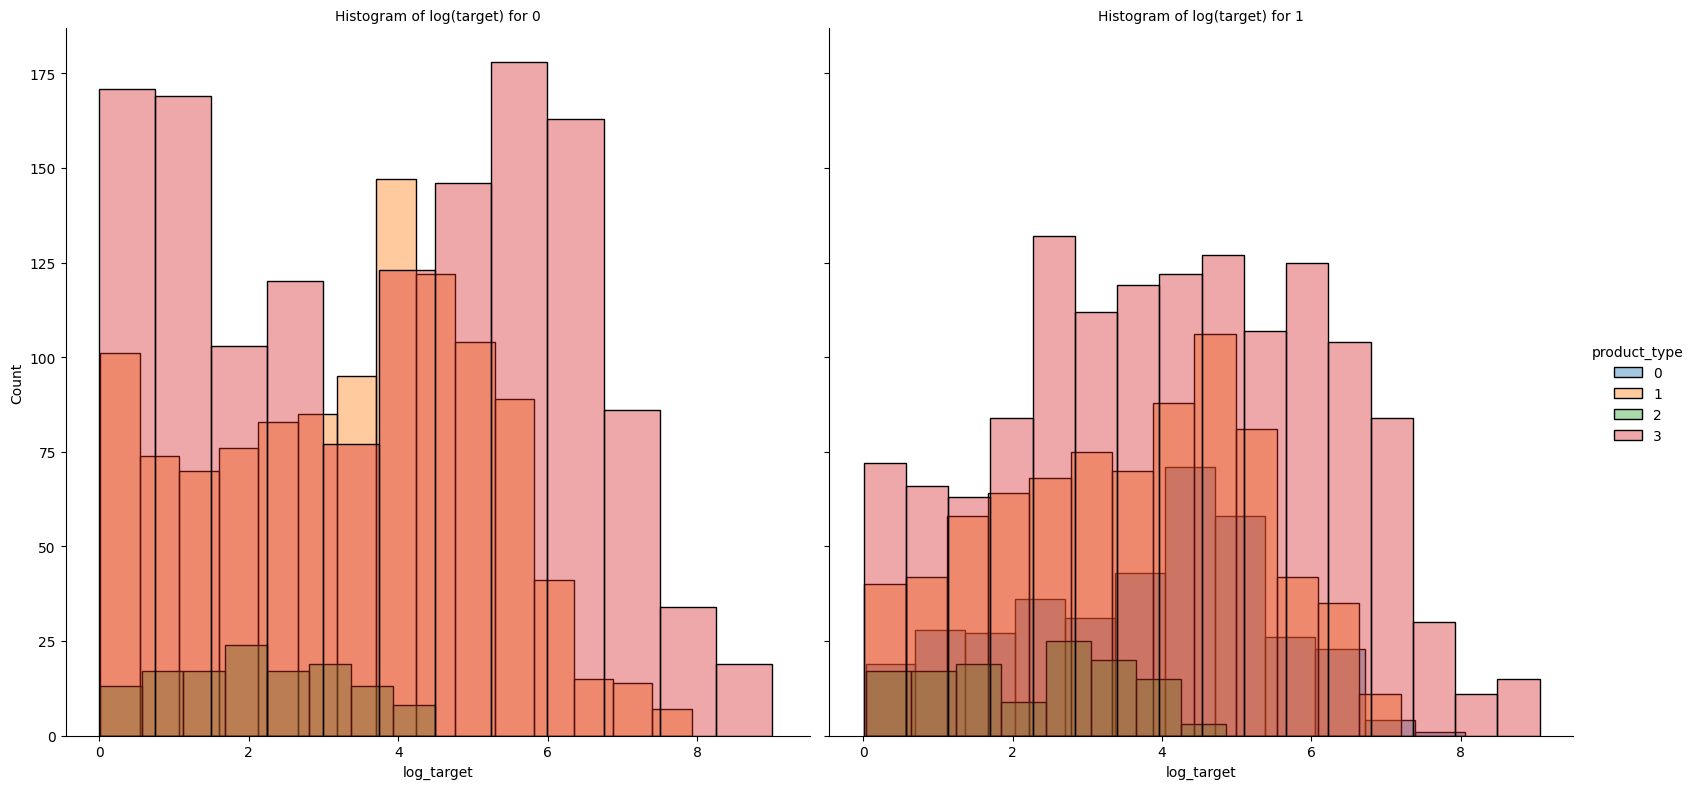

In [14]:
# Set the default figure size for all subsequent plots
plt.rcParams['figure.figsize'] = (10, 8)

# Create a FacetGrid with two columns, one for each binomial variable
g = sns.FacetGrid(sample_df, col='is_business', hue='product_type', height=8, aspect=1)

# Map a scatter plot onto the grid
g.map(sns.histplot, 'log_target', alpha=0.4)
g.add_legend()
# Set labels and title for each subplot
g.set_titles('Histogram of log(target) for {col_name}')

Notice the different distributions among Non-Business and Business. Also product_type distributions are very similar the most significant difference is the type 3 (Spot) has way more observations than the others. There are way more type 0 (Combined) than type 2 (General Service).

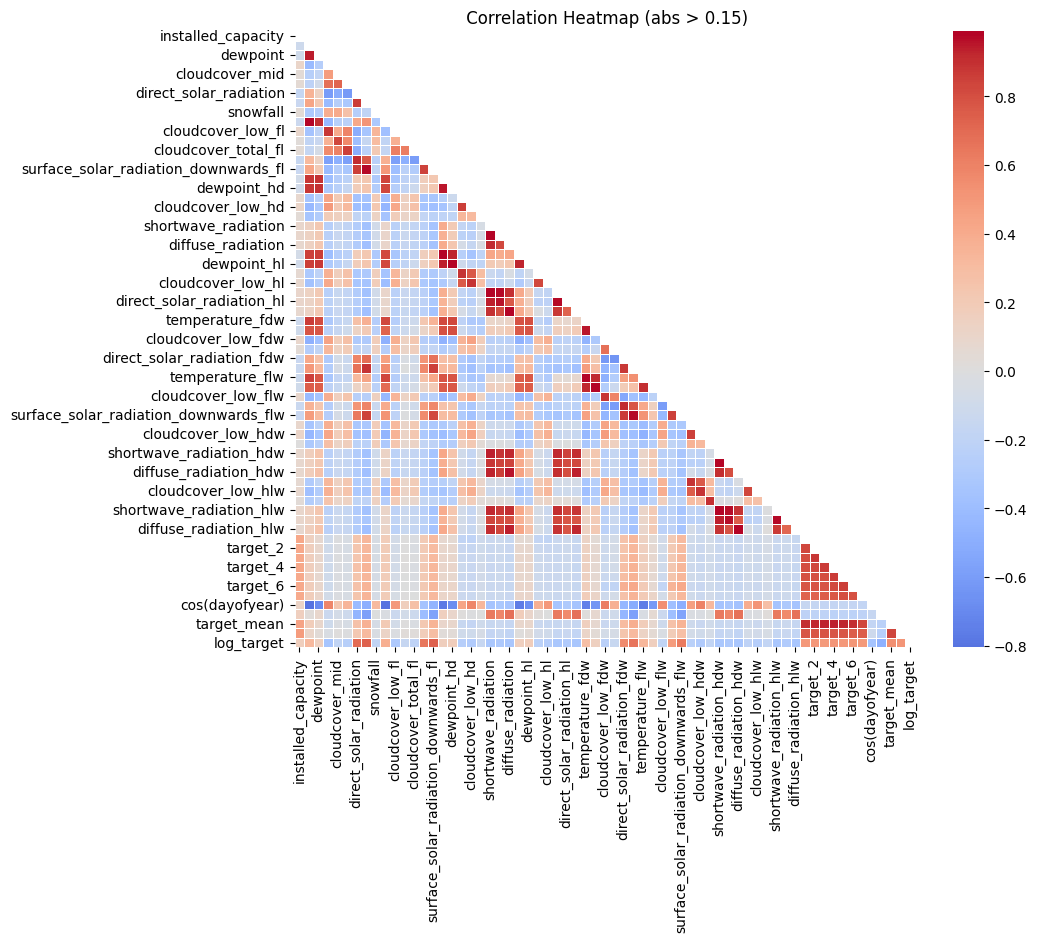

In [18]:
def corr_heatmap(df, title):
    num_cols = df.columns[df.dtypes == 'float32']
    corr_mat = df[[*num_cols, 'log_target']].corr()
    filt_corr_mat = corr_mat[np.abs(corr_mat['log_target']) > 0.15]
    filt_corr_mat = filt_corr_mat[filt_corr_mat.index]
    mask = np.triu(np.ones_like(filt_corr_mat, dtype=bool))
    sns.heatmap(filt_corr_mat, cmap='coolwarm', mask=mask, linewidths=.5, center=0)
    plt.title(f'{title} Correlation Heatmap (abs > 0.15)')

corr_heatmap(sample_df, '')

Judging by the correlation matrix the approach will be to fit a Random Forest since it deals quite well with the multicollinearity of the target lag variables.

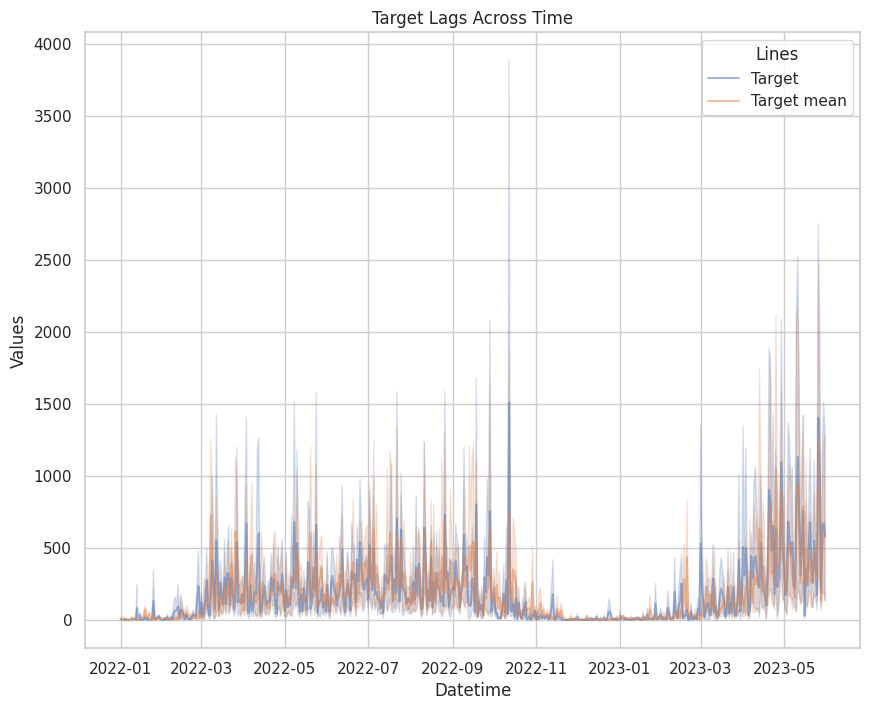

In [30]:
sns.set(style="whitegrid")
def line_plot(df=sample_df):
    # Plot multiple lines using Seaborn
    sample_df['datetime'] = pd.to_datetime(sample_df[['year', 'month', 'day']])
    sns.lineplot(x='datetime', y='target', alpha=0.5, data=df, label='Target')
    sns.lineplot(x='datetime', y='target_mean', alpha=0.5, data=df, label='Target mean')
    

    # Set labels and title
    plt.xlabel('Datetime')
    plt.ylabel('Values')
    plt.title('Target Lags Across Time')

    # Display the plot
    plt.legend(title='Lines', loc='upper right')
line_plot()

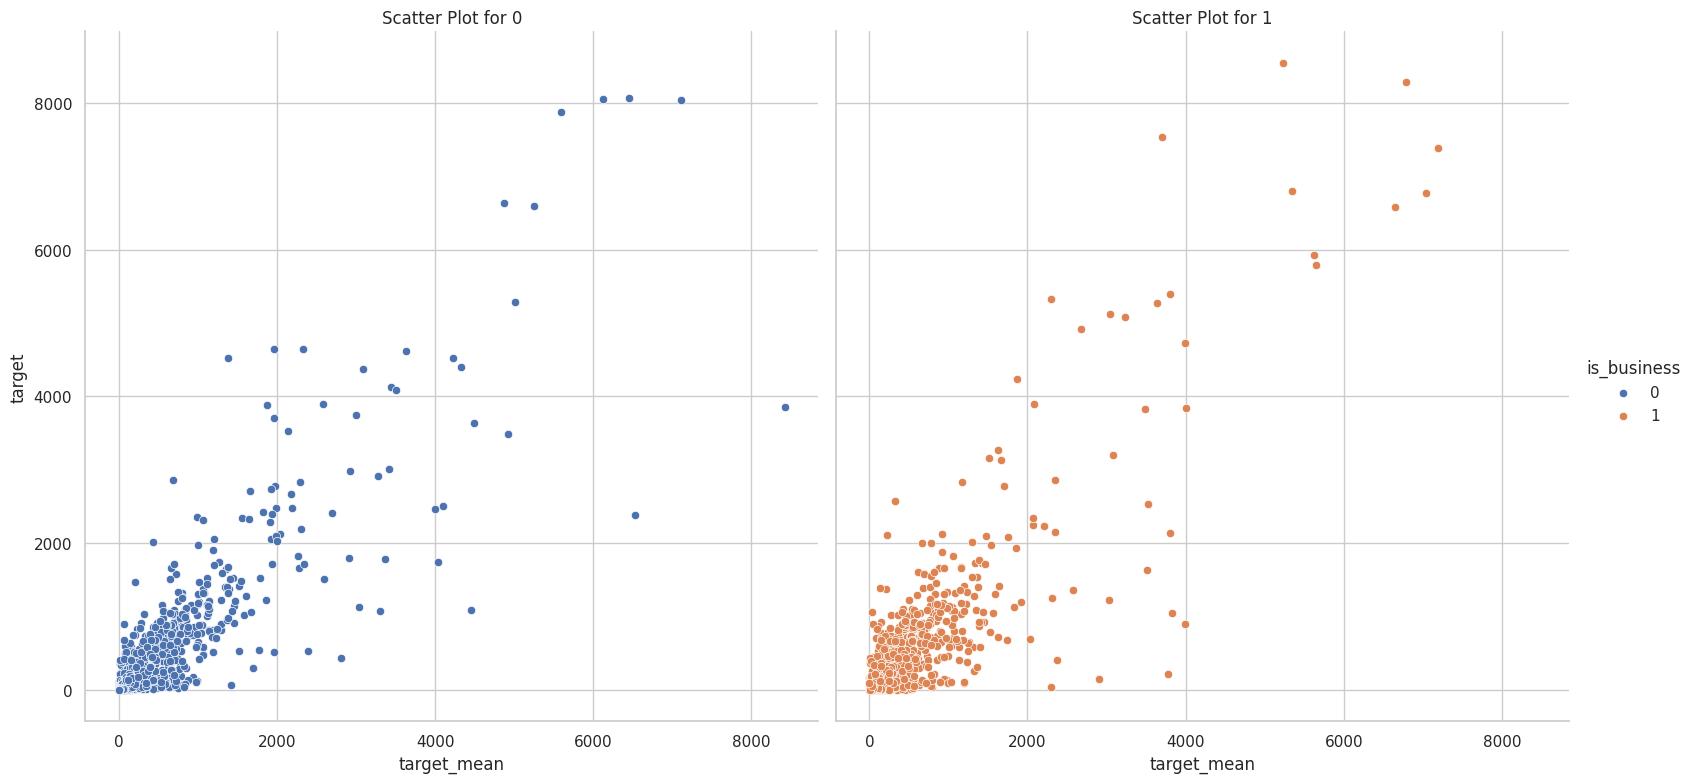

In [33]:
# Set the default figure size for all subsequent plots
plt.rcParams['figure.figsize'] = (10, 8)

# Create a FacetGrid with two columns, one for each binomial variable
g = sns.FacetGrid(sample_df, col='is_business', hue='is_business', height=8, aspect=1)

# Map a scatter plot onto the grid
g.map(sns.scatterplot, 'target_mean', 'target')
g.add_legend()
# Set labels and title for each subplot
g.set_titles('Scatter Plot for {col_name}')

No significant difference was found between non-business and business energy prosumers.

# Models

We need to 1 hot encode some of the features like month, county and product_type

In [34]:
def one_hot_encode(df, col_name):
    encoded_col = pd.get_dummies(df[col_name], prefix=col_name, drop_first=False)
    df = pd.concat([df, encoded_col], axis=1).drop(col_name, axis=1)
    return df

In [50]:
train_prod = one_hot_encode(sample_df, 'month')
train_prod = one_hot_encode(train_prod, 'county')
train_prod = one_hot_encode(train_prod, 'product_type')
train_prod = train_prod.drop(columns='log_target')
train_prod = train_prod.drop(columns=['date','datetime','category_1','is_consumption'])

In [55]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV


param_grid = {'max_depth': [5, 10, 15, 20],
              'n_estimators':[100,150,200,250]}
base_estimator = RandomForestRegressor(random_state=1, criterion='absolute_error')
sh = HalvingGridSearchCV(base_estimator, param_grid, cv=5,
                          factor=3, resource='n_samples').fit(train_prod.drop(columns='target'), train_prod['target'])
rf = sh.best_estimator_

In [57]:
rf = RandomForestRegressor(random_state=1, criterion='absolute_error', max_depth=10, n_estimators=100).fit(train_prod.drop(columns='target'), train_prod['target'])

Text(0.5, 1.0, 'Top 15 Feature importance')

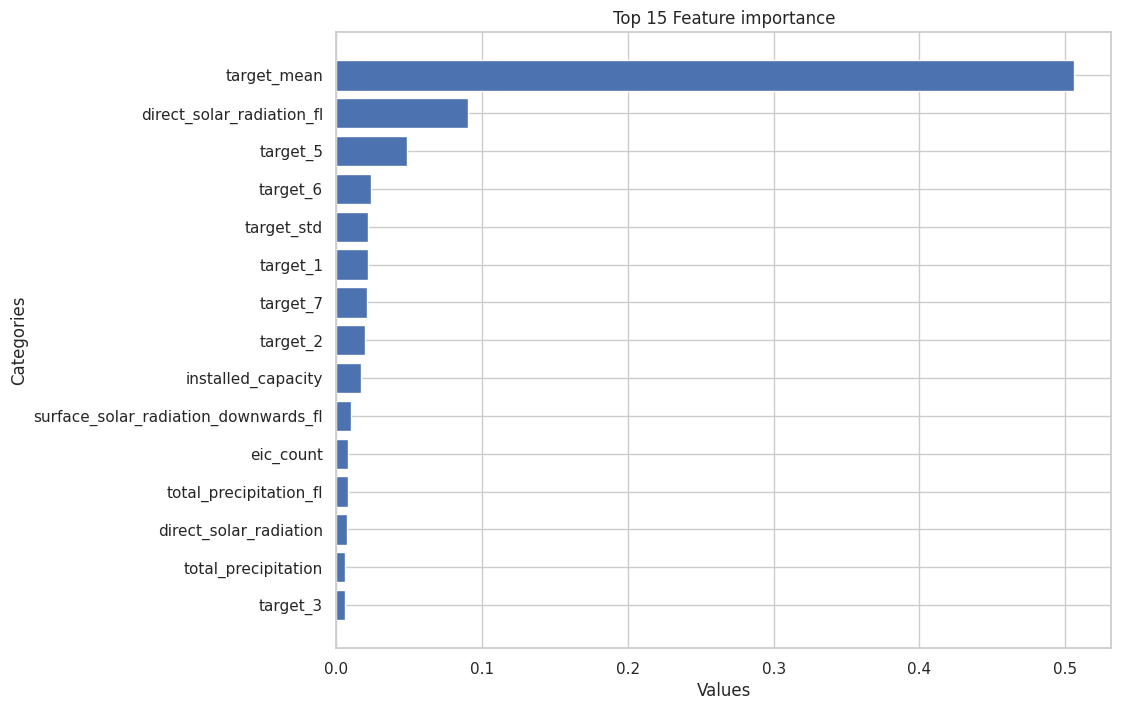

In [61]:
feature_importance_df = pd.DataFrame({'Feature': train_prod.drop(columns='target').columns, 'Importance': rf.feature_importances_})

# Sort the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).head(15)
feature_importance_df

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
# Set labels and title
plt.xlabel('Values')
plt.ylabel('Categories')
plt.title('Top 15 Feature importance')

To validate my data I used the predict function on the rest of the training set.

In [113]:
df_val = df_train[df_train['is_consumption']==0].copy()
df_val = df_train[df_train['target'] > 0].dropna()
df_val = one_hot_encode(df_val, 'month')
df_val = one_hot_encode(df_val, 'county')
df_val = one_hot_encode(df_val, 'product_type')

In [116]:
y_pred = rf.predict(df_val.drop(['target','category_1','is_consumption'],axis=1))

results = pd.DataFrame({'Y Predictions':y_pred,
                        'Y True values':df_val['target']})
results

,Y Predictions,Y True values
row_id,,
366049,178.179310,442.226
366051,27.102950,44.899
366052,1.861385,0.015
366053,858.764490,1743.197
366055,53.406775,247.800
...,...,...
2018344,7.266885,2.287
2018345,69.354110,117.332
2018347,141.479840,197.233


In [118]:
MAE = np.mean(np.abs(results['Y Predictions'] - results['Y True values']))
MAE

150.29723515786304

# Conclusion

The training time on a random forest with 100 n_estimators and 10 max_depth from Sci-kit learn, took way longer than expected (more than 3 hours). No other models were tested because of not having enough resources to run the models for a couple hours and then solve the multicollinearity issues with these data. This is a mayor issue for participating in further competitions and a way to schedule and keep the results saved needs to be found in future research, another solution could be to take a more software engineering approach and put together an application that can more reliably store the trained models since the main issue here is the memory allocated to training the models with such large datasets.

On the results, a MAE of 150 on the 1.5M dataset seems very good for the first atempt, looking at the leaderboard it lands within the top 800s, there is a lot more to be learned and looking forward to seeing the end of the competition and how the winners put together there models, which is the best part of participating in this kind of events.